# Ice Draft

This notebook plots Ocean1 and Ocean2 ice draft anomaly from the linear interpolation of input files, to show how different model groups interpolated and smoothed the files.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

Models: 
```
COCO   MITgcm-BAS          MITgcm-JPL  MOM6_SIGMA_ZSTAR  NEMO-CNRS      POP2x
FVCOM  MITgcm_BAS_Coupled  MOM6        MPAS-Ocean        NEMO-UKESM1is  ROMS-UTAS
```

In [7]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)

def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


# Plot difference from linear mean of input file

In [8]:
expt = Ocean1_COM
labels = get_labels(expt)

data = xr.open_dataset(basedrive+expt[0], decode_times=False).iceDraft


In [9]:
input1 = xr.open_dataset(baserepo+'Ocean1_input_geom_v1.01.nc') #need to have this file! Link in Asay-Davis et al. (2016)
input2 = xr.open_dataset(baserepo+'Ocean2_input_geom_v1.01.nc')


In [10]:
linear_interp1 = xr.zeros_like(data)

for x in np.arange(len(data.nx)):
    for y in np.arange(len(data.ny)):
        linear_interp1[y,x] = 0.25*(input1.lowerSurface[2*y,2*x]+input1.lowerSurface[2*y,2*x+1]+
                                    input1.lowerSurface[2*y+1,2*x]+input1.lowerSurface[2*y+1,2*x+1])

linear_interp2 = xr.zeros_like(data)

for x in np.arange(len(data.nx)):
    for y in np.arange(len(data.ny)):
        linear_interp2[y,x] = 0.25*(input2.lowerSurface[2*y,2*x]+input2.lowerSurface[2*y,2*x+1]+
                                    input2.lowerSurface[2*y+1,2*x]+input2.lowerSurface[2*y+1,2*x+1])

grounded1 = xr.zeros_like(data)

for x in np.arange(len(data.nx)):
    for y in np.arange(len(data.ny)):
        grounded1[y,x] = 0.25*(input1.groundedMask[2*y,2*x]+input1.groundedMask[2*y,2*x+1]+
                                    input1.groundedMask[2*y+1,2*x]+input1.groundedMask[2*y+1,2*x+1])

grounded2 = xr.zeros_like(data)

for x in np.arange(len(data.nx)):
    for y in np.arange(len(data.ny)):
        grounded2[y,x] = 0.25*(input2.groundedMask[2*y,2*x]+input2.groundedMask[2*y,2*x+1]+
                                    input2.groundedMask[2*y+1,2*x]+input2.groundedMask[2*y+1,2*x+1])

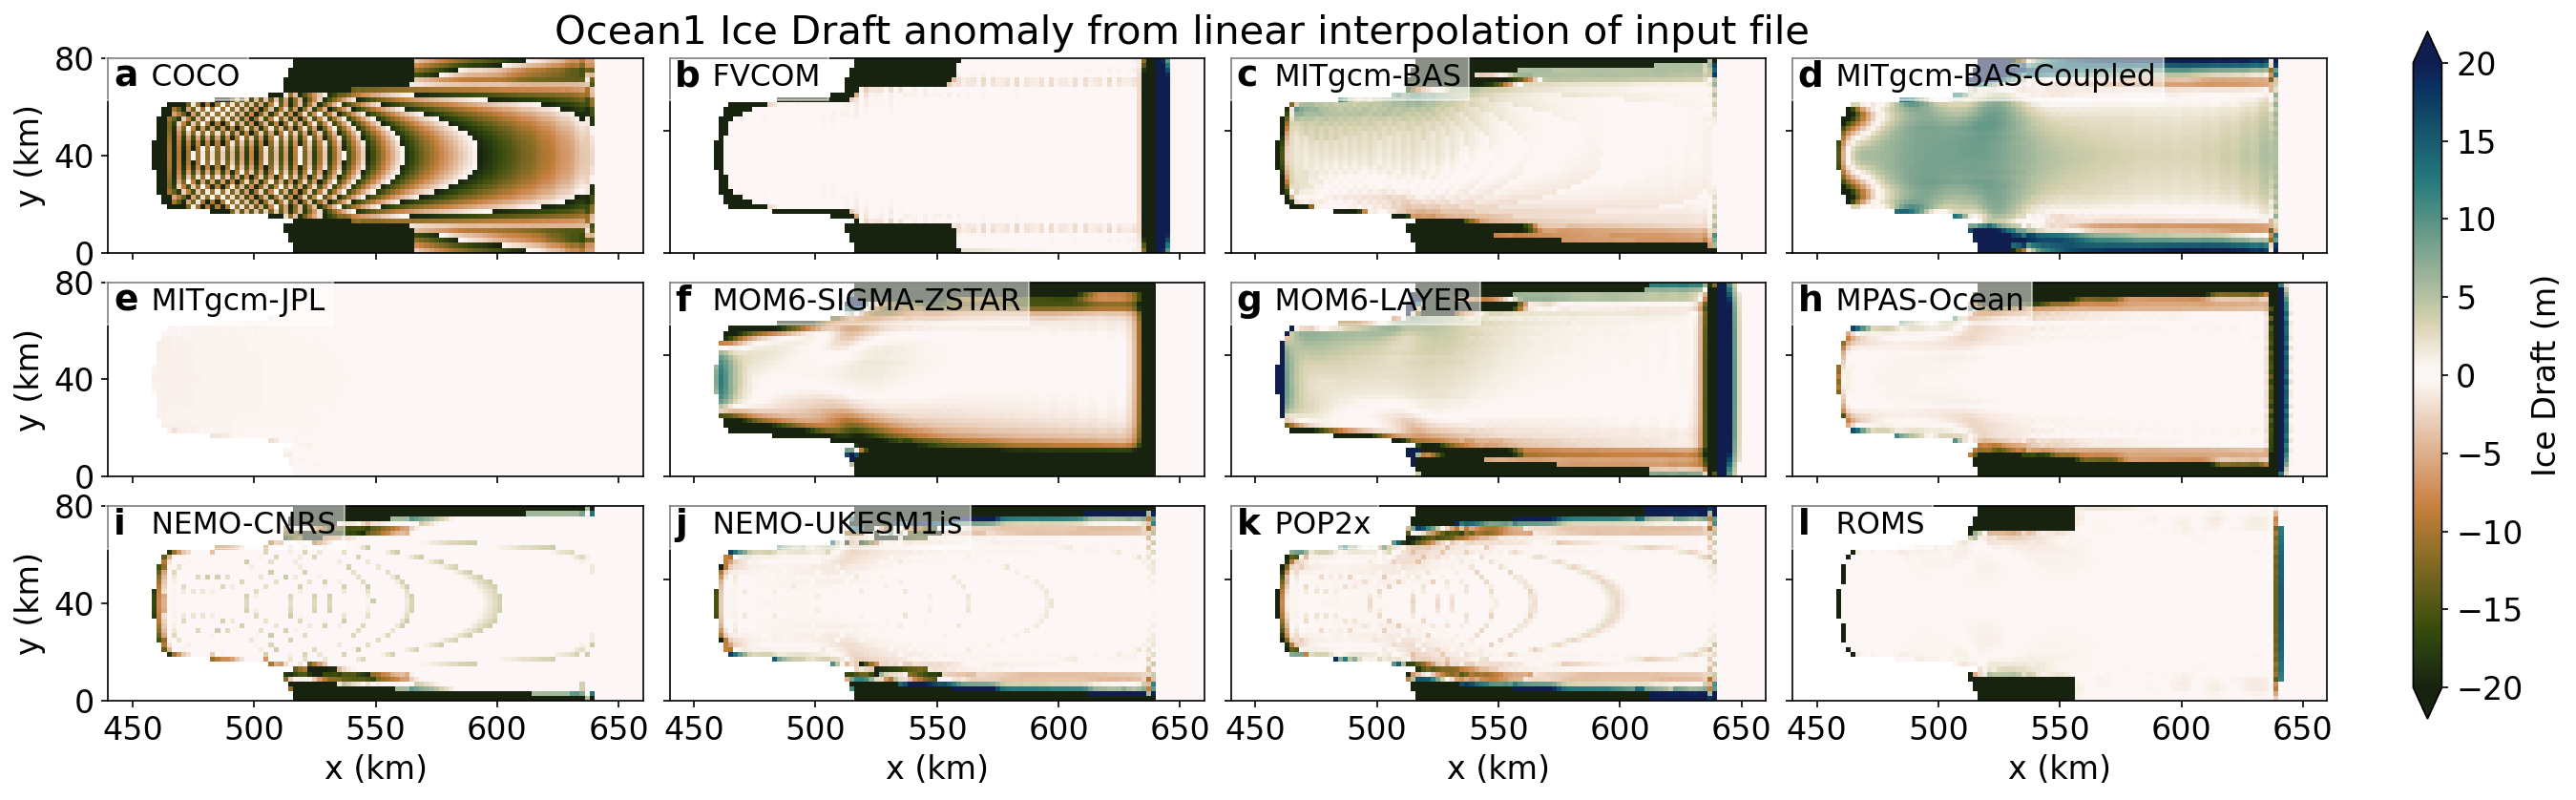

In [11]:
expt = Ocean1_COM
labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
nrows = int(np.ceil(length/3))
fig = plt.figure(figsize=(20, 6),facecolor='w',dpi = 150)

vmin = -20.
vmax = 20.

xlim = [440., 660.]

for i in np.arange(length):
    ax = plt.subplot(3,nrows,i+1)
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    data = data.set_coords(['x', 'y', 'time'])
    nTime = data.sizes['nTime']
    try:
        draft = data.iceDraft.isel(nTime=0)#.mean('nTime')
    except ValueError: #not time-dependent
        draft = data.iceDraft
    draft = draft.where(draft<1e36)
    mesh = plt.pcolormesh(
        1e-3 * data.x.values, 1e-3 * data.y.values, (np.abs(draft.fillna(0))-np.abs(linear_interp1).where(grounded1==0)).values, 
        cmap=cm.cm.tarn, vmin=vmin, vmax=vmax, shading='nearest')
    plt.xlim(xlim)
    mesh.axes.set_aspect('equal')
    
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top',bbox=dict(facecolor='w', alpha=0.5,ec = 'w'))
    plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('y (km)', fontsize = 16)
        plt.yticks([0,40,80])
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)', fontsize = 16)
    else:
        plt.xlabel('')
    plt.tick_params(labelsize=16)

cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(mesh, cax=cax, extend='both')
cbar.ax.set_ylabel('Ice Draft (m)', fontsize = 16)
plt.tick_params(labelsize=16)
fig.subplots_adjust(wspace = 0.05, hspace = 0.05)

fig.suptitle('Ocean1 Ice Draft anomaly from linear interpolation of input file', fontsize = 20, y=0.92);

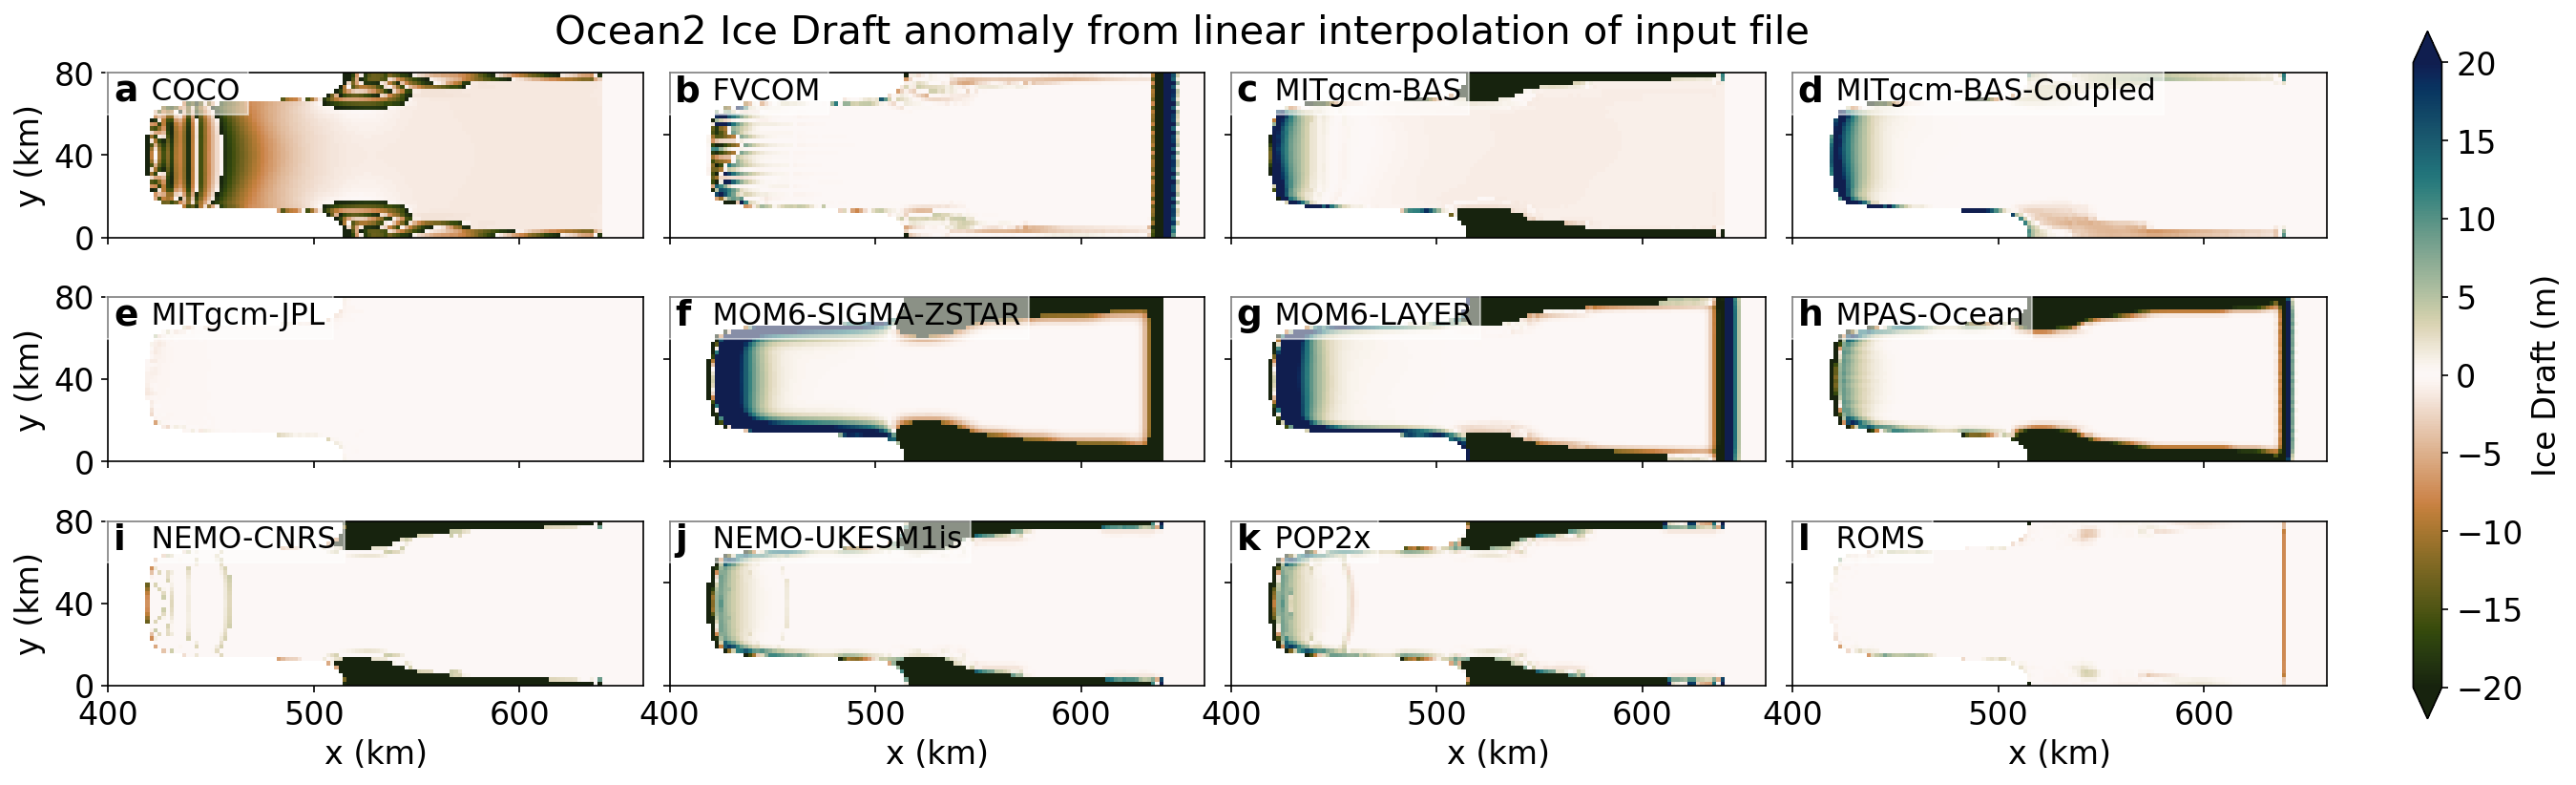

In [12]:
expt = Ocean2_COM
labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
nrows = int(np.ceil(length/3))
fig = plt.figure(figsize=(20, 6),facecolor='w',dpi = 150)

vmin = -20.
vmax = 20.

xlim = [400., 660.]

for i in np.arange(length):
    ax = plt.subplot(3,nrows,i+1)
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    data = data.set_coords(['x', 'y', 'time'])
    nTime = data.sizes['nTime']
    try:
        draft = data.iceDraft.isel(nTime=0)#.mean('nTime')
    except ValueError: #not time-dependent
        draft = data.iceDraft
    draft = draft.where(draft<1e36)
    mesh = plt.pcolormesh(
        1e-3 * data.x.values, 1e-3 * data.y.values, (np.abs(draft.fillna(0))-np.abs(linear_interp2).where(grounded2==0)).values, 
        cmap=cm.cm.tarn, vmin=vmin, vmax=vmax, shading='nearest')
    plt.xlim(xlim)
    mesh.axes.set_aspect('equal')
    
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top',bbox=dict(facecolor='w', alpha=0.5,ec = 'w'))
    plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('y (km)', fontsize = 16)
        plt.yticks([0,40,80])
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)', fontsize = 16)
    else:
        plt.xlabel('')
    plt.tick_params(labelsize=16)

cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(mesh, cax=cax, extend='both')
cbar.ax.set_ylabel('Ice Draft (m)', fontsize = 16)
plt.tick_params(labelsize=16)
fig.subplots_adjust(wspace = 0.05, hspace = 0.05)

fig.suptitle('Ocean2 Ice Draft anomaly from linear interpolation of input file', fontsize = 20, y=0.92);